In [ ]:
# basic library
import pandas as pd
import numpy as np
import re
import string
import os
# import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# model
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# stop words
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# stememer
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# nltk corpus
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# tokenizer
from transformers import BertTokenizer
from tokenizers import Tokenizer

# vectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# other preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# training pipline
import tensorflow as tf
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# label encoding
label_type = ['NotPromotion', 'Promotion']

In [6]:
# %load_ext cudf.pandas

# %pip install seaborn
# %pip install Sastrawi
# %pip install wordcloud
# %pip install torch
# %pip install transformers
# %pip install nltk
# %pip install tensorflow
# %pip install gensim --upgrade
# %pip install Sastrawi
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [2]:
combined_data = pd.read_csv('../../Dataset/dataset_combined_new - dataset_combined_new.csv', sep=',')
training_data = pd.read_csv('../../Dataset/train.csv', sep=',').dropna()
testing_data = pd.read_csv('../../Dataset/test.csv', sep=',')
validation_data = pd.read_csv('../../Dataset/val.csv')

# training_data = training_data.sample(frac = 1)
training_data.head()

,text,label
0,Mencari pengalaman daring yang lancar? AERO88 ...,1
1,Itu kayanya di kasih tanda deh yg bisa di lewa...,0
2,Whatsapp Telegram Livechat Daftar Login Hdtoto...,1
3,KO SELASA SI BABG,0
4,"TERLEPAS DARI GAME NYA YANG BAGUS, SEMOGA BANG...",0


In [ ]:
print("train isna:",training_data['text'].isna().sum())
print("test isna:",testing_data['text'].isna().sum())
print("val isna:",validation_data['text'].isna().sum())

print(training_data[training_data['text'].isna()][['text', 'label']])


train isna: 0
test isna: 0
val isna: 0
Empty DataFrame
Columns: [text, label]
Index: []


# Preprocessing

In [3]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
drop_stopwords = ['pula', 'pasti', 'amat', 'ingin', 'sampai']

stopwords += custom_stopwords
stopwords = [word for word in stopwords if word not in drop_stopwords]

pattern = r"[^A-Za-z ]"

print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 's

In [4]:
def preprocess_text(texts):
    sentences=[]
    for index, text in enumerate(texts):

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]
        
        text = ' '.join(word_list)
        texts[index] = text
        sentences.append(word_list)
    return texts, sentences

In [5]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_val = validation_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_val = validation_data['label'].values.copy()
y_test = testing_data['label'].values.copy()

In [6]:
texts_train,sentences = preprocess_text(texts_raw_train)
texts_val,_ = preprocess_text(texts_raw_val)
texts_test,_ = preprocess_text(texts_raw_test)

texts_train

array(['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .',
       'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru',
       'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+',
       ..., 'Kerennn',
       'Saya merekomendasikan ρ

In [15]:
print(len(sentences))
print(sentences)

2736
[['Mencari', 'pengalaman', 'daring', 'lancar', '?', 'AERO88', 'mungkin', 'solusinya', '.'], ['Itu', 'kayanya', 'kasih', 'tanda', 'deh', 'lewatin', 'apa', 'ngga', ',', 'contohnya', 'kerucut+tong', 'sampah', 'biru'], ['Whatsapp', 'Telegram', 'Livechat', 'Daftar', 'Login', 'Hdtoto', 'Beranda', 'Slot', 'Online', 'Live', 'Casino', 'Sportsbook', 'Arcade', 'Togel', 'Poker', 'slider', 'Jackpot', 'Daily', 'Wins', 'Gates', 'of', 'Olympus', 'Bonanza', 'Gold', '<', 'Starlight', 'Princess', 'Sweet', 'power', 'thor', 'megaways', 'Treasure', 'Wild', 'Aztec', 'Gems', 'Gatot', 'Kaca', 'Popular', 'Games', 'bowl', 'Mahjong', 'Ways', 'Break', 'Away', 'Lucky', 'Wilds', 'Koi', 'Gate', '1000', 'Wishes', 'Gem', 'Saviour', 'Conquest', 'Chronicles', 'X', 'Up', 'Gold', 'Blitz', 'Elven', 'Roma', 'Silverback', 'Multiplier', 'Mountain', 'Fiery', 'Sevens', 'Hot', 'Phoenix', 'Rises', 'Neko', 'Fortune', 'Tiger', 'garuda', 'Treasures', 'Bandito', 'fireworks', 'Dreams', 'Macau', 'Rooster', 'Rumble', '>', 'Platform'

# Tokenization & Vectorizer

In [7]:
# Define parameters

EMBEDDING_DIM = 300
MAX_LEN = 128

## Torch Tokenization

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train)

train_texts_seq = tokenizer.texts_to_sequences(texts_train)
val_texts_seq = tokenizer.texts_to_sequences(texts_val)
test_texts_seq = tokenizer.texts_to_sequences(texts_test)

train_texts_padded = pad_sequences(train_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')
val_texts_padded = pad_sequences(val_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')
test_texts_padded = pad_sequences(test_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [18]:
train_texts_padded.shape

(2736, 128)

## Word2Vec Vectorizer 

In [19]:
# w2v_model = Word2Vec(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,     # smaller vector size
    window=5,
    min_count=1,        # allow all words
    sg=1,               # skip-gram
    negative=10,        # stronger negative sampling
    epochs=30,          # more passes over data
    workers=1,          # deterministic for small data
)
embedding_words = list(w2v_model.wv.key_to_index)

In [20]:
w2v_model.wv.most_similar('untung')

[('segede', 0.9190170764923096),
 ('secuil', 0.9126772284507751),
 ('gunung', 0.9112871289253235),
 ('berkali-kali', 0.8977707624435425),
 ('lipat', 0.8963333964347839),
 ('lgnsung', 0.8703687191009521),
 ('DEWADORA', 0.8682942986488342),
 ('🤪', 0.8645294308662415),
 ('disono', 0.8643803596496582),
 ('😜', 0.8642241358757019)]

In [64]:
w2v_model.vector_size

300

In [66]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
VOCAB_SIZE

11021

In [86]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

In [ ]:
vocab_size = len(tokenizer.word_index)
w2v_vocab_size = len(w2v_model.wv.key_to_index)
missing_count = 0

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        missing_count += 1
        print(i, end=" ")
        # Initialize missing words with random small numbers instead of zeros
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, EMBEDDING_DIM)

print(f"Total words in tokenizer: {vocab_size}")
print(f"Total words in Word2Vec: {w2v_vocab_size}")
print(f"Words not found in Word2Vec: {missing_count} ({(missing_count/vocab_size*100):.2f}%)")

8 22 49 71 94 103 107 109 116 124 131 148 154 155 156 170 196 198 202 206 207 232 235 236 239 241 259 288 300 313 318 320 333 344 346 354 359 365 375 386 388 394 396 398 413 417 432 433 438 440 446 453 457 475 480 489 490 495 513 531 533 565 568 576 580 586 590 596 603 610 613 617 620 623 626 628 634 636 640 651 656 663 664 666 668 674 676 679 689 692 699 704 713 714 716 719 722 726 727 734 737 744 748 755 769 772 777 788 798 805 806 809 816 824 830 835 847 878 888 890 892 893 899 913 914 936 943 951 955 968 969 970 971 972 976 980 981 983 985 986 990 991 999 1012 1015 1025 1032 1036 1037 1043 1046 1049 1050 1076 1077 1078 1079 1080 1082 1083 1084 1085 1087 1094 1108 1109 1111 1112 1113 1114 1118 1120 1121 1124 1129 1141 1144 1145 1146 1168 1169 1171 1172 1174 1181 1183 1184 1185 1186 1187 1203 1204 1214 1216 1217 1218 1219 1221 1222 1236 1240 1251 1253 1255 1258 1261 1266 1267 1268 1269 1273 1287 1291 1298 1302 1304 1305 1306 1307 1311 1315 1325 1329 1330 1336 1339 1341 1344 1345 1350

# Training

In [68]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

drop_value = 0.2
# n_dense = 24
print("vocab size:", VOCAB_SIZE)

vocab size: 11021


In [69]:
model = Sequential()

model.add(Embedding(
    input_dim=VOCAB_SIZE, 
    output_dim=EMBEDDING_DIM, 
    weights=[embedding_matrix], 
    trainable=True
    ))
# model.add(GlobalAveragePooling1D())
model.add(SpatialDropout1D(drop_value))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))

# model.add(GlobalAveragePooling1D())
model.add(Flatten())

# Fully connected layers
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     3,306,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,300 (12.61 MB)

 Trainable params: 3,306,300 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [70]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.685027541311968, 1: 1.851150202976996}

In [109]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

checkpoint_callback = ModelCheckpoint(filepath='best_model_checkpoint.keras',  
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=False,  # Save full model (architecture + weights)
                                      verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

num_epochs = 100
history = model.fit(
    train_texts_padded,
    y_train,
    validation_data=(val_texts_padded,y_val),
    epochs=num_epochs,
    callbacks=[checkpoint_callback],
    class_weight=class_weights
)


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7299 - loss: 1.3003
Epoch 1: val_accuracy improved from -inf to 0.72886, saving model to best_model_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.7298 - loss: 1.3001 - val_accuracy: 0.7289 - val_loss: 1.2460
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7325 - loss: 1.2305
Epoch 2: val_accuracy improved from 0.72886 to 0.73178, saving model to best_model_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.7325 - loss: 1.2304 - val_accuracy: 0.7318 - val_loss: 1.1743
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7448 - loss: 1.1569
Epoch 3: val_accuracy improved from 0.73178 to 0.75510, saving model to best_model_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.7447 - loss: 1.1568 - val_accuracy: 0.7551 - val_loss: 1.1125
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7474 - loss: 1.1025
E

In [110]:
from tensorflow.keras.models import load_model
model = load_model("best_model_checkpoint.keras")

model.save("../Model/LSTM_WORD2VEC_TORCH_EMBEDDING_TRAINABLETRUE.h5")
model.save("../Model/LSTM_WORD2VEC_TORCH_EMBEDDING_TRAINABLETRUE.keras")

# Eval

In [9]:
from tensorflow.keras.models import load_model

model = load_model("../../Trained Model - H5 - TF/LSTM_WORD2VEC_TORCH_EMBEDDING_TRAINABLETRUE.keras")

c:\Users\tyogo\.conda\envs\nlp\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
model.evaluate(test_texts_padded, y_test, verbose=0)


[0.14837487041950226, 0.9736841917037964]

In [137]:
best_epoch = np.argmin(history.history['val_loss']) + 1
best_epoch

43

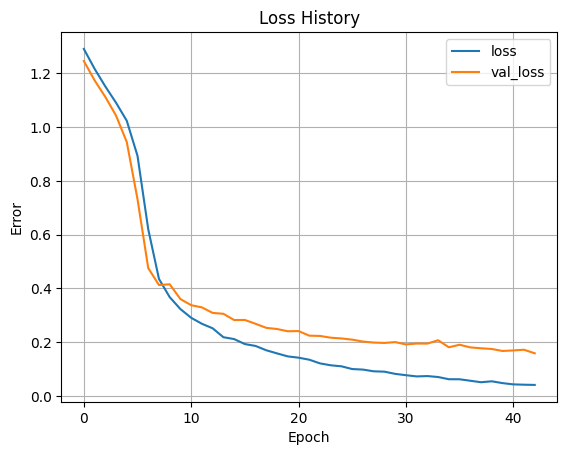

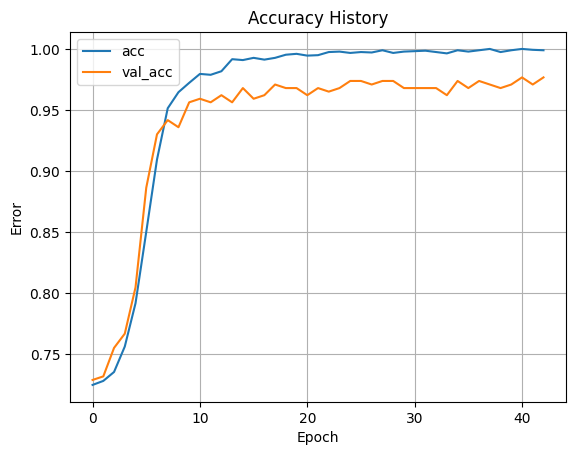

In [122]:
plt.plot(history.history['loss'][:best_epoch], label='loss')
plt.plot(history.history['val_loss'][:best_epoch], label='val_loss')
# plt.ylim([0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title("Loss History")
plt.show()

plt.plot(history.history['accuracy'][:best_epoch], label='acc')
plt.plot(history.history['val_accuracy'][:best_epoch], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title("Accuracy History")
plt.grid(True)

In [ ]:
from sklearn.metrics import precision_recall_curve, fbeta_score

y_probs = model.predict(test_texts_padded)
y_probs = y_probs.flatten()

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

fbeta_scores = []
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    score = fbeta_score(y_test, y_pred,beta=0.5,average='binary',pos_label=1)
    fbeta_scores.append(score)

fbeta_scores = np.array(fbeta_scores)
best_idx = fbeta_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F-Beta Score: {fbeta_scores[best_idx]:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
Best Threshold: 0.9710
Best F1-Score: 0.9674
Average Precision (AP) Score: 0.9939


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Accuracy Score: 0.9824561403508771
F1 Score: 0.967391304347826
Recall Score: 0.967391304347826
Precision Score: 0.967391304347826
Classification Report: 
              precision    recall  f1-score   support

NotPromotion       0.99      0.99      0.99       250
   Promotion       0.97      0.97      0.97        92

    accuracy                           0.98       342
   macro avg       0.98      0.98      0.98       342
weighted avg       0.98      0.98      0.98       342

Confusion Matrix:



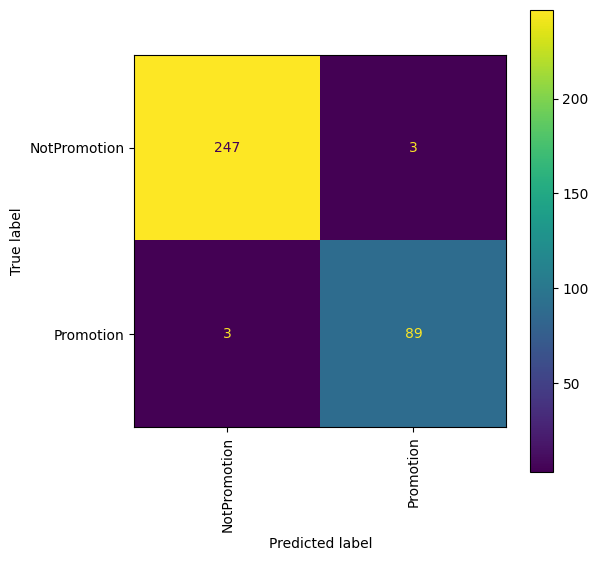

In [12]:
pred = model.predict(test_texts_padded)
y_pred = [0 if pred < best_threshold else 1 for pred in pred]

print(f"Accuracy Score: {accuracy_score(y_pred, y_test)}")
print(f"F1 Score: {f1_score(y_pred, y_test)}")
print(f"Recall Score: {recall_score(y_pred, y_test)}")
print(f"Precision Score: {precision_score(y_pred, y_test)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(6,6))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')
plt.show()

In [ ]:
from sklearn.metrics import fbeta_score

fbeta = fbeta_score(y_test, y_pred,
                   beta=0.5,
                   average='binary',
                   pos_label=1
)

fbeta

0.967391304347826

: 

In [18]:
for idx,i in enumerate(y_pred):
    if i != y_test[idx]:
        print(idx+1,")❌pred:", i, "| label:", y_test[idx], texts_test[idx])
        continue
    print(idx+1,") pred:", i, "| label:", y_test[idx], texts_test[idx])

1 ) pred: 1 | label: 1 INFO CINA777APK CINA777RTP CINA777Logo24/11/2024 ( Min ) 14.56 ( GMT+07 ) Versi MobileVersi WAP ( NEX4D ) Nama PenggunaKata SandiLupa Kata Sandi ? DaftarHomeTogelHot GamesSlotsLive CasinoOlahragaCrash GameArcadePokerE-SportsSabung AyamPromosiWelcome to situs resmi CINA777 | Kami membayar berapapun kemenangan player.HasilPasaranBuku MimpiHasil TerakhirStatistik MarketGame PopulerMahjong Wins 3 – Black ScatterMAINMahjong Wins 3 – Black ScatterMahjong WaysMAINMahjong WaysMighty HerculesMAINMighty HerculesSlot88 BonanzaMAINSlot88 BonanzaLe PharaohMAINLe PharaohPirate Quest 1000MAINPirate Quest 1000SixSixSixMAINSixSixSixWay of NinjaMAINWay of Ninja888 GoldMAIN888 GoldMahjong Ways 2MAINMahjong Ways 2Gates of Olympus 1000™MAINGates of Olympus 1000™Wild Bounty ShowdownMAINWild Bounty ShowdownLucky Twins NexusMAINLucky Twins NexusNexus Koi GateMAINNexus Koi GateThe CryptMAINThe CryptLucky Twins Power ClustersMAINLucky Twins Power ClustersMentalMAINMentalFortune Gems 2MAIN

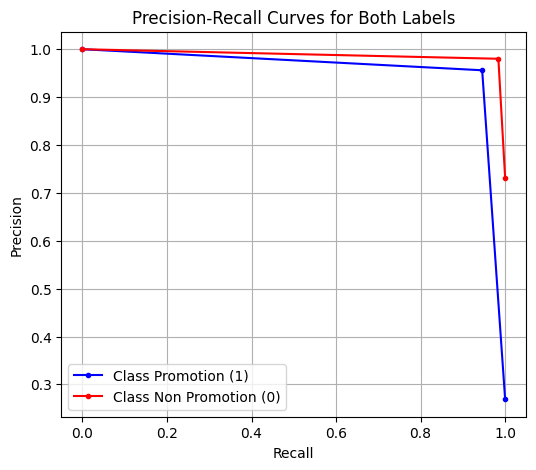

In [265]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision-recall values for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred)

# Compute precision-recall values for class 0 (negative class)
y_scores_neg = 1 - np.array(y_pred)  # Since model predicts class 1 probabilities, class 0 is (1 - probability)
precision_0, recall_0, _ = precision_recall_curve(1 - y_test, y_scores_neg)

# Plot Precision-Recall curves for both classes
plt.figure(figsize=(6, 5))
plt.plot(recall_1, precision_1, marker='.', label=f'Class Promotion (1)', color='blue')
plt.plot(recall_0, precision_0, marker='.', label=f'Class Non Promotion (0)', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Both Labels')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def predict_sentiment(text):
    use_text,_ = preprocess_text(text)
    # inputs = tokenizer(use_text, padding=True, truncation=True, return_tensors='tf', max_length=512)
    use_text = tokenizer.texts_to_sequences(use_text)
    use_text = pad_sequences(use_text, maxlen=MAX_LEN, padding='post', truncating='post')

    pred = model.predict(use_text)
    # pred_labels = tf.argmax(pred, axis=1)
    pred_labels = [0 if pred < best_threshold else 1 for pred in pred]
    # print(pred)
 
    pred_labels = [label_type[label] for label in pred_labels]
    for index, preds in enumerate(pred_labels):
        print(f"{text[index]}: {preds}")
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs    yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar.",
    "dapatkan banyak rejekii di DEWADORА!"
]
predict_sentiment(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Aku seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial , Cak Imin : 8,8 Juta Pasien Minta Direhabilitasi Jumat , 15 Nov: NotPromotion
Gacor xxtoto menang pasti dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: NotPromotion
gacor pasti menang xxtoto: Promotion
top up kantorbola pasti gampang menangnya: Promotion
gratis koin buruan topup agencasinoindonesia: NotPromotion
gratis koin buruan topup fairbet88.com , segera daftarkan akun: NotPromotion
DEWA-DORA tuh situs paling enak withdraw tiap hari ! 😖 😣: Promotion
DEWA-DORA tuh situs paling gampang narik tiap hari ! 😖 😣: Promotion
Gua setia maen DEWADORA , tempat terbaik !: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung Menang berapapun dibayar .: Promotion
dapatkan banyak rejekii DEWADORА !: Promotion
